In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.neighbors import NearestNeighbors
import cv2
from PIL import ImageEnhance
from skimage import exposure
import gc




donwload the dataset

In [2]:
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101:3.0.2',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
    data_dir="data",
)

preprocess the data set sin preprocess_input, it is a function to normalize our images, for VGG19 is recomended use it

In [3]:

def reduce_noise(img_array):
    # Convertir la imagen a formato adecuado para OpenCV
    img_cv = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    # Aplicar filtro Gaussiano
    img_denoised = cv2.GaussianBlur(img_cv, (5, 5), 0)
    # Convertir de vuelta a formato PIL
    img_denoised = cv2.cvtColor(img_denoised, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_denoised)


def adjust_contrast_brightness(img):
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(1.5)  # Aumentar el contraste
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(1.2)  # Aumentar el brillo
    return img


def equalize_histogram(img_array):
    img_array = exposure.equalize_hist(img_array)
    return img_array



In [4]:
# Parámetros de procesamiento
base_dir = '/content/data/downloads/extracted/TAR_GZ.101_ObjectCategories.tar.gz/101_ObjectCategories'
target_size = (220, 220)  # Tamaño deseado para redimensionamiento

# Nombre de la carpeta a excluir
exclude_folder = 'BACKGROUND_Google'

# Inicialización de listas
images_list = []
labels_list = []

# Iterar sobre las carpetas (clases) en la carpeta base
for class_name in os.listdir(base_dir):
    if class_name == exclude_folder:
        continue  # Omitir la carpeta no deseada

    class_dir = os.path.join(base_dir, class_name)

    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)

            try:
                # Leer la imagen usando PIL
                with Image.open(img_path) as img:
                    # Convertir imagen a RGB si no es RGB
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    # Redimensionar imagen a un tamaño fijo usando LANCZOS
                    img_resized = img.resize(target_size, Image.LANCZOS)

                    # Convertir imagen a un array de NumPy
                    img_array = np.array(img_resized, dtype='float32')

                    # Asegurar que la imagen procesada tenga la forma correcta
                    if img_array.shape == (target_size[1], target_size[0], 3):  # (alto, ancho, canales)
                        images_list.append(img_array)
                        labels_list.append(class_name)
                    else:
                        print(f"Imagen ignorada debido a dimensiones inconsistentes: {img_path}, tamaño: {img_array.shape}")

            except Exception as e:
                print(f"Error al procesar la imagen {img_path}: {e}")

# Convertir listas a arrays de NumPy
images_array = np.array(images_list)
labels_array = np.array(labels_list)

# Liberar memoria de las listas
del images_list
del labels_list
gc.collect()

print("Imágenes procesadas y clases almacenadas en memoria.")

# Normalizar imágenes con preprocess_input para VGG19
images_array = preprocess_input(images_array)

# Dividir en conjuntos de entrenamiento y prueba
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    images_array,  # Imágenes procesadas
    labels_array,  # Nombres de las clases
    test_size=0.3,     # 30% para prueba
    random_state=42,   # Para reproducibilidad
    stratify=labels_array,  # Asegura que la proporción de clases sea la misma en ambos conjuntos
    shuffle=True       # Barajar los datos antes de dividir
)

# Verificar el tamaño de los datos después de dividir
print(f"Tamaño del conjunto de entrenamiento: {train_imgs.shape}")
print(f"Tamaño del conjunto de prueba: {test_imgs.shape}")

# Liberar memoria de los arrays no utilizados
del images_array
del labels_array
gc.collect()


Imágenes procesadas y clases almacenadas en memoria.
Tamaño del conjunto de entrenamiento: (6073, 220, 220, 3)
Tamaño del conjunto de prueba: (2604, 220, 220, 3)


0

In [ ]:

# Parámetros de procesamiento
base_dir = '/content/data/downloads/extracted/TAR_GZ.101_ObjectCategories.tar.gz/101_ObjectCategories'
target_size = (100, 100)  # Tamaño deseado para redimensionamiento

# Nombre de la carpeta a excluir
exclude_folder = 'BACKGROUND_Google'

# Inicialización de listas
images_list = []
labels_list = []

# Iterar sobre las carpetas (clases) en la carpeta base
for class_name in os.listdir(base_dir):
    if class_name == exclude_folder:
        continue  # Omitir la carpeta no deseada

    class_dir = os.path.join(base_dir, class_name)

    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)

            try:
                # Leer la imagen
                with Image.open(img_path) as img:
                    # Convertir imagen a RGB si no es RGB
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    # Redimensionar imagen a un tamaño fijo usando LANCZOS
                    img_resized = img.resize(target_size, Image.LANCZOS)

                    # Convertir imagen a un array de NumPy
                    img_array = np.array(img_resized, dtype='float32')

                    # Asegurar que la imagen procesada tenga la forma correcta
                    if img_array.shape == (target_size[1], target_size[0], 3):  # (alto, ancho, canales)
                        images_list.append(img_array)
                        labels_list.append(class_name)
                    else:
                        print(f"Imagen ignorada debido a dimensiones inconsistentes: {img_path}, tamaño: {img_array.shape}")

            except Exception as e:
                print(f"Error al procesar la imagen {img_path}: {e}")

# Convertir listas a arrays de NumPy
images_array = np.array(images_list)
labels_array = np.array(labels_list)

# Liberar memoria de las listas
del images_list
del labels_list

print("Imágenes procesadas y clases almacenadas en memoria.")

# Normalizar imágenes con preprocess_input para VGG19
images_array = preprocess_input(images_array)

# Dividir en conjuntos de entrenamiento y prueba
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    images_array,  # Imágenes procesadas
    labels_array,  # Nombres de las clases
    test_size=0.3,     # 30% para prueba
    random_state=42,   # Para reproducibilidad
    stratify=labels_array,  # Asegura que la proporción de clases sea la misma en ambos conjuntos
    shuffle=True       # Barajar los datos antes de dividir
)

# Verificar el tamaño de los datos después de dividir
print(f"Tamaño del conjunto de entrenamiento: {train_imgs.shape}")
print(f"Tamaño del conjunto de prueba: {test_imgs.shape}")

# Liberar memoria de los arrays no utilizados
del images_array
del labels_array


Imágenes procesadas y clases almacenadas en memoria.
Tamaño del conjunto de entrenamiento: (6073, 100, 100, 3)
Tamaño del conjunto de prueba: (2604, 100, 100, 3)


load the modelo VGG19

In [5]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

define function de extract features of the images

In [6]:
import gc
gc.collect()


0

In [7]:
def extract_features(images, model, batch_size=32):
    num_images = images.shape[0]
    feature_dim = np.prod(model.output_shape[1:])  # Tamaño total de características basado en la salida del modelo
    features = np.empty((num_images, feature_dim))  # Inicializar array para almacenar características

    # Obtener el número de procesadores disponibles
    num_workers = os.cpu_count() or 1  # Usar 1 si os.cpu_count() devuelve None

    def predict_batch(start, end):
        batch_images = images[start:end]
        batch_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        feature_maps = model.predict(batch_tensor)

        # Aplanar las características si el modelo devuelve múltiples dimensiones
        batch_features = np.array([feature_map.flatten() for feature_map in feature_maps])
        return start, end, batch_features

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = []
        for start in range(0, num_images, batch_size):
            end = min(start + batch_size, num_images)
            futures.append(executor.submit(predict_batch, start, end))

        for future in as_completed(futures):
            start, end, batch_features = future.result()
            features[start:end] = batch_features

    return features


In [8]:
features_train = extract_features(train_imgs, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━

In [9]:
print(f"Tamaño de las características extraídas: {features_train.shape}")

Tamaño de las características extraídas: (6073, 4608)


***retrieval***

In [11]:
num_neighbors = 10
nn_model = NearestNeighbors(n_neighbors=num_neighbors, algorithm='ball_tree').fit(features_train)


In [12]:
# Supongamos que test_imgs y test_labels son arrays de NumPy
num_samples = test_imgs.shape[0]  # Número total de muestras en test_imgs

# Selección aleatoria de un índice
random_index = np.random.randint(0, num_samples)

# Obtener la imagen y la etiqueta correspondiente
query_image = test_imgs[random_index]
label_query = test_labels[random_index]

print(f"Índice seleccionado: {random_index}")
print(f"Etiqueta de la imagen: {label_query}")

Índice seleccionado: 595
Etiqueta de la imagen: bonsai


we use a desnormalized function for plot or show the images

In [13]:
def desnormalized(img):
  mean = [103.939, 116.779, 123.68]  # Media para VGG19
  std = [1, 1, 1]  # Desviación estándar (simplificado para este ejemplo)

  # Deshacer la normalización
  img_denormalized = img * std + mean

  # Convertir de BGR a RGB (si es necesario)
  img_denormalized = img_denormalized[..., ::-1]

  # Asegurar que los valores estén entre 0 y 255
  img_denormalized = np.clip(img_denormalized, 0, 255).astype(np.uint8)
  return img_denormalized

process the query image for this runtime

In [14]:
query_desnormalized = desnormalized(query_image)
query_image = tf.expand_dims(query_image, axis=0)
query_desnormalized=tf.expand_dims(query_desnormalized, axis=0)

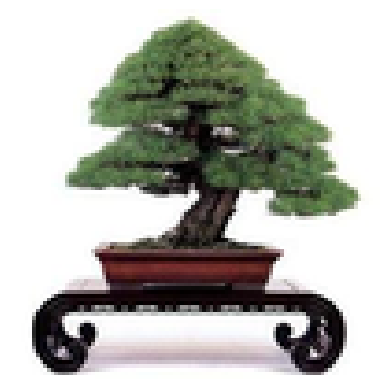

In [15]:
import matplotlib.pyplot as plt

plt.imshow(query_desnormalized[0])
plt.axis('off')
plt.show()

calculate the distances with neighboors

In [16]:
query_features = model.predict([query_image]).flatten().reshape(1, -1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [17]:
distances, indices = nn_model.kneighbors(query_features)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

Indices of nearest neighbors: [[ 679  959 1204 4225 1419 1761 5728  472 1582  936]]
Distances to nearest neighbors: [[607.26049286 619.96422349 626.32161275 627.4208968  628.33222245
  629.002732   634.21559758 635.09786242 637.5064649  637.96519983]]


In [18]:
# Ordenar distancias e índices en orden ascendente (más cercanos primero)
sorted_indices = np.argsort(distances[0])  # Ordena los índices basados en las distancias
sorted_distances = distances[0][sorted_indices]  # Ordena las distancias usando los índices
sorted_indices = indices[0][sorted_indices]  # Reorganiza los índices de vecinos usando los índices ordenados

print("Indices of nearest neighbors:", sorted_indices)
print("Distances to nearest neighbors:", sorted_distances)

Indices of nearest neighbors: [ 679  959 1204 4225 1419 1761 5728  472 1582  936]
Distances to nearest neighbors: [607.26049286 619.96422349 626.32161275 627.4208968  628.33222245
 629.002732   634.21559758 635.09786242 637.5064649  637.96519983]


In [19]:
retrieved_images = []
retrieved_labels = []
for indice in sorted_indices.flatten():
    retrieved_images.append(desnormalized(train_imgs[indice]))
    retrieved_labels.append(train_labels[indice])


In [20]:
retrieved_labels

['bonsai',
 'panda',
 'menorah',
 'menorah',
 'menorah',
 'wrench',
 'garfield',
 'chandelier',
 'airplanes',
 'garfield']

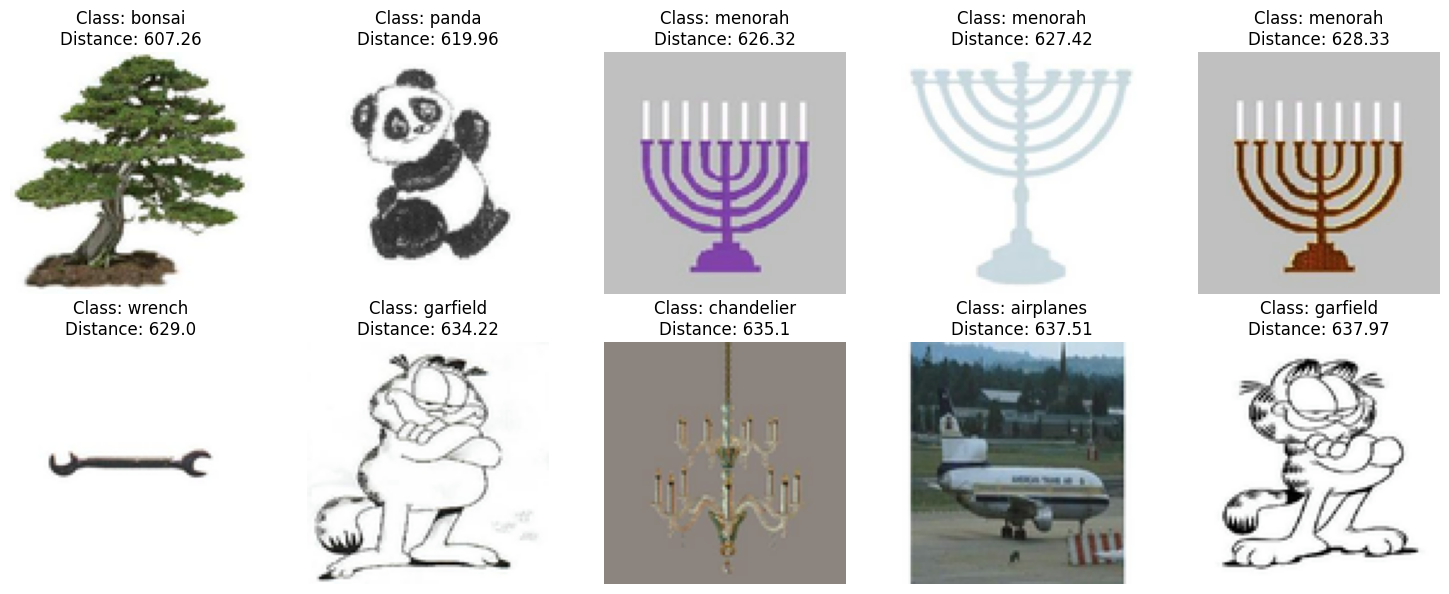

In [21]:

# Número de columnas deseadas
num_columns = 5

# Número de filas calculado en función del número total de imágenes
num_images = len(retrieved_images)
num_rows = int(np.ceil(num_images / num_columns))

# Crear la figura con la cuadrícula deseada
plt.figure(figsize=(num_columns * 3, num_rows * 3))

for i, image in enumerate(retrieved_images):
    row = i // num_columns
    col = i % num_columns
    plt.subplot(num_rows, num_columns, i + 1)
    plt.imshow(image)
    plt.title(f"Class: {retrieved_labels[i]}\nDistance: {round(distances[0][i], 2)}")
    plt.axis('off')

# Ajustar el espaciado para que no se superpongan
plt.tight_layout()
plt.show()

# Evaluate

In [ ]:
def process_image(img):
    query_image = tf.expand_dims(img, axis=0)
    query_features = model.predict([query_image]).flatten().reshape(1, -1)
    distances, indices = nn_model.kneighbors(query_features)
    retrieved_labels = []
    for indice in indices.flatten():
      retrieved_labels.append(train_labels[indice])
    return retrieved_labels





In [ ]:
import time
def metrics(dataset,labels):
  precision_scores = []
  recall_scores = []
  true_positive = 0
  false_positive = 0
  false_negative = 0
  for idx, img in enumerate(dataset):
    retrieved_labels = process_image(img)
    for retrieved_label in retrieved_labels:
      if retrieved_label == labels[idx]:
        true_positive += 1
      else:
        false_positive += 1
    relevant_labels = [label for label in train_labels if label == labels[idx]]
    false_negative = len(relevant_labels) - true_positive

    # Calcular precisión y recall
    if (true_positive + false_positive) > 0:
        precision = true_positive / (true_positive + false_positive)
    else:
        precision = 0

    if (true_positive + false_negative) > 0:
        recall = true_positive / (true_positive + false_negative)
    else:
        recall = 0

    precision_scores.append(precision)
    recall_scores.append(recall)
    """ if idx == 100:
      break"""
  average_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
  average_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0

  return average_precision, average_recall



In [ ]:
average_precision, average_recall = metrics(test_imgs,test_labels)
print(f'Average Precision: {average_precision}')
print(f'Average Recall: {average_recall}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [ ]:
import numpy as np
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
from sklearn.neighbors import NearestNeighbors
import time

# Función para procesar una sola imagen
def process_image(img):
    query_image = tf.expand_dims(img, axis=0)
    query_features = model.predict(query_image).flatten().reshape(1, -1)
    distances, indices = nn_model.kneighbors(query_features)

    retrieved_labels = [train_labels[indice] for indice in indices.flatten()]
    return retrieved_labels

# Función para calcular métricas en paralelo
def compute_metrics_for_batch(batch_images, batch_labels):
    precision_scores = []
    recall_scores = []

    for img, true_label in zip(batch_images, batch_labels):
        retrieved_labels = process_image(img)

        true_positive = sum(retrieved_label == true_label for retrieved_label in retrieved_labels)
        false_positive = sum(retrieved_label != true_label for retrieved_label in retrieved_labels)
        relevant_labels = [label for label in train_labels if label == true_label]
        false_negative = len(relevant_labels) - true_positive

        # Calcular precisión y recall
        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)

    return precision_scores, recall_scores

# Función principal para calcular métricas en todo el dataset
def metrics(dataset, labels, batch_size=32):
    num_images = len(dataset)
    precision_scores = []
    recall_scores = []

    # Procesar en paralelo usando ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        futures = []
        for start in range(0, num_images, batch_size):
            end = min(start + batch_size, num_images)
            batch_images = dataset[start:end]
            batch_labels = labels[start:end]
            futures.append(executor.submit(compute_metrics_for_batch, batch_images, batch_labels))

        for future in futures:
            batch_precision_scores, batch_recall_scores = future.result()
            precision_scores.extend(batch_precision_scores)
            recall_scores.extend(batch_recall_scores)

    # Calcular precisión y recall promedio
    average_precision = np.mean(precision_scores) if precision_scores else 0
    average_recall = np.mean(recall_scores) if recall_scores else 0

    return average_precision, average_recall

# Medir el tiempo total de ejecución
start_time = time.time()

# Ejecutar la función que deseas medir
average_precision, average_recall = metrics(test_imgs, test_labels)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [84]:
print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Tiempo transcurrido: {elapsed_time:.2f} segundos")

Average Precision: 0.5322964669738863
Average Recall: 0.11435719038858254
Tiempo transcurrido: 255.74 segundos
